<a href="https://colab.research.google.com/github/morganFitzg/fashion_annotation/blob/main/Capstone_model_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flatiron Capstone: Fashion Image Annotation

Morgan Fitzgerald

Instructor: Abhineet Kulkarni

## Business Understanding

This project builds a proof of concept for a data pipeline that produces Instagram trend reports using information from the post images.

While hashtag and comment data is readily available, one cannot always ascertain the kind of clothing being pictured from this information.  When making marketing or product development decisions, trend data that includes more specific details on what clothing is being pictured could be very useful. Additionally, fashion influencers, journalists, and stylists could benefit from more detailed trend data.

Ultimately, the end user can view the data/results in a google data studio report built from a MySQL Google Cloud database.  The report can be filtered to show different time frames and data from specific categories and also provides a view of the images with the most likes from the selected clothing category.

## Data Understanding

The data used to train this model comes from the [iMaterialist fashion attribute dataset](https://arxiv.org/abs/1906.05750).  The dataset contains over a million images annotated with 8 different attributes.  Our model predicts three of these attributes: category, color and pattern.

Upon examination of the data (in this notebook), it was clear that there is a significant amount of mislabeled data and certain labels could easily be confounded.  For example there are separate labels for 'jeans' and 'skinny jeans', yet images of skinny jeans being labeled as 'jeans'. Care was taken to simplify some of these confusing categories and group similar categories where a distinction is not critical for trend analysis.  

After cleaning the data, the clothing category attribute has 57 different categories, pattern has 23 and color has 15.  

With such a large number of images, it was not possible in the timeframe allocated for this project to correct mislabeling, but to increase accuracy of the model it would be important increase the quality of the data.

## Model

The model performing annotations was built using transfer learning with the VGG16 image classification model as a backbone with three additional dense layers added with three branches, one for each attribute. The weights in the VGG16 layers were frozen during training.  Due to resource and time constraints, the model was trained on approximately 100,000 of the million images available. Training was performed in two rounds, two epochs each for two sets of approximately 50,000 images.

The overall performance for the model is not at the level that would be required to deploy for commercial use, but it is far better than random guessing.  Below are the validation accuracy scores for each attribute:

<ol>
<li>Category: 48%</li>
<li>Pattern: 75%</li>
<li>Color: 53%</li>
</ol>

There are a number of ways that accuracy could be increased given more time and resources for the project. A few are listed below:

<ol>
<li>Improve data labeling</li>
<li>Train the model on more images</li>
<li>Unfreeze the weights in VGG16 layers during training to fine tune</li>
<li>Add dense layers</li>
<li>Investigate categories that are frequently mislabeled</li>
<li>Try different loss function/optimizer</li>
</ol>

Ultimately, this project is more about a proof of concept and with 59, 23, and 15 categories respectively within each attribute the model is clearly achieving much higher accuracy than random guessing.  Research is ongoing in the field of image and especially fashion image annotation, as this is a challenging problem and a commercial grade model would require more time, resources, and perhaps some adjustments to the architecture.

Finally, there are limitations to this model that could be addressed with a more complex architecture. When finding attributes, this model assumes there is only one piece of clothing pictured. However, in many cases there would be multiple items such as a shirt and pants or a dress and jacket. There are neural networks designed to identify different clothing articles within an image (and locate them) allowing different attributes to be assigned to each article. However, this was outside the scope of this project. 

# Setup

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 17 14:57:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    375MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence, to_categorical
from keras.losses import CategoricalCrossentropy

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
import io 
from PIL import Image

In [ ]:
#config
IMAGE_SIZE=(224,224,3)
epochs=3
batch_size=32
path='/content/drive/My Drive/fashion_annotation/images/'
train_path='/content/drive/My Drive/fashion_annotation/imgs_train1/'
val_path='/content/drive/My Drive/fashion_annotation/imgs_val1/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

The iMaterialist dataset was cleaned and formatted in a separate notebook.

In this section, the data is separated into six separate groups stratified by the category attribute (and verified that the other attributes were also properly stratified). This is necessary because the images are downloaded onto google drive which times out when trying to access a file in a folder with too many files.  Therefore, separate subfolders where created for the training and validation sets of each of these 6 splits.

In [ ]:
data=pd.read_csv('/content/drive/My Drive/fashion_annotation/data_v2.csv')

In [ ]:
data.head()

,imageId,category,color,pattern,url
0,7,Nightgowns,White,None,http://contestimg.wish.com/api/webimage/52cbee...
1,8,Blouses,Black,Mesh,http://contestimg.wish.com/api/webimage/53994b...
2,11,Skirts,Green,None,http://contestimg.wish.com/api/webimage/51bd84...
3,13,Dresses,Black,None,http://contestimg.wish.com/api/webimage/53e099...
4,14,Dresses,Black,None,http://contestimg.wish.com/api/webimage/543e92...


In [ ]:
cat_num=data['category'].nunique()
pat_num=data['pattern'].nunique()
col_num=data['color'].nunique()
print(cat_num)
print(pat_num)
print(col_num)

57
23
15


Integer codes for each of the attribute's categories are created as required for the keras to_categorical function that is used in the Image Generator.

In [ ]:
#create numerical codes for the category and pattern labels
data.category=pd.Categorical(data.category)
data['cat_codes']=data.category.cat.codes
data.pattern=pd.Categorical(data.pattern)
data['pat_codes']=data.pattern.cat.codes
data.color=pd.Categorical(data.color)
data['col_codes']=data.color.cat.codes

#make key for the codes
pattern_key=data.groupby('pattern').mean()['pat_codes'].astype(int)
category_key=data.groupby('category').mean()['cat_codes'].astype(int)
color_key=data.groupby('color').mean()['col_codes'].astype(int)
color_key

color
Beige           0
Black           1
Blue            2
Brown           3
Gold            4
Gray            5
Green           6
Multi Color     7
Orange          8
Pink            9
Purple         10
Red            11
Silver         12
White          13
Yellow         14
Name: col_codes, dtype: int64

In [ ]:
pattern_key=pattern_key.reset_index()
category_key=category_key.reset_index()
color_key=color_key.reset_index()

In [ ]:
#save keys for use in other notebook to translate prediction back to text
pattern_key.to_csv('/content/drive/My Drive/fashion_annotation/pattern_key.csv')
category_key.to_csv('/content/drive/My Drive/fashion_annotation/category_key.csv')
color_key.to_csv('/content/drive/My Drive/fashion_annotation/color_key.csv')

In [ ]:
#split data into 6 parts to train separately
#stratify based on category label

X=data['url']
y=data[['cat_codes','pat_codes','col_codes']]

test_sizes=[.83,.8,.75,.67,.5]

splits=[]

for ts in test_sizes:
  X_use, X, y_use, y = train_test_split(X,y,test_size=ts,
                                        random_state=42,
                                        stratify=y['cat_codes'])
  split=pd.concat([X_use,y_use],axis=1)
  print(split.shape)
  splits.append(split)

last_split=pd.concat([X,y],axis=1)
print(last_split.shape)
splits.append(last_split)

(68323, 4)
(66715, 4)
(66716, 4)
(66048, 4)
(67050, 4)
(67050, 4)


In [ ]:
train_0, val_0=folds[0]

In [ ]:
#check distribution of classes across labels in all splits

#number of classes per label

class_counts=[]

for split in splits:
  class_num={}
  class_num['train_cat']=split['cat_codes'].nunique()
  class_num['train_pat']=split['pat_codes'].nunique()
  class_num['train_col']=split['col_codes'].nunique()
  class_counts.append(class_num)

class_counts_df=pd.DataFrame(class_counts)
class_counts_df

,train_cat,train_pat,train_col
0,57,23,15
1,57,23,15
2,57,23,15
3,57,23,15
4,57,23,15
5,57,23,15


In [ ]:
#create train and val sets in each split and verify stratification of labels
train_val_splits=[]
class_counts=[]

for split in splits:
  X=split['url']
  y=split[['cat_codes','pat_codes','col_codes']]
  X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=.2,
                                               stratify=y['cat_codes'])
  train_data=pd.concat([X_train,y_train],axis=1)
  val_data=pd.concat([X_val,y_val],axis=1)
  train_val_splits.append((train_data,val_data))

  class_num={}
  class_num['train_cat']=train_data['cat_codes'].nunique()
  class_num['val_cat']=val_data['cat_codes'].nunique()
  class_num['train_pat']=train_data['pat_codes'].nunique()
  class_num['val_pat']=val_data['pat_codes'].nunique()
  class_num['train_col']=train_data['col_codes'].nunique()
  class_num['val_col']=val_data['col_codes'].nunique()
  class_counts.append(class_num)

counts_df=pd.DataFrame(class_counts)
counts_df

,train_cat,val_cat,train_pat,val_pat,train_col,val_col
0,57,57,23,23,15,15
1,57,57,23,23,15,15
2,57,57,23,23,15,15
3,57,57,23,23,15,15
4,57,57,23,23,15,15
5,57,57,23,23,15,15


In [ ]:
#save each train and val df as csv for reproducability

for n in range(6):
  train=train_val_splits[n][0]
  val=train_val_splits[n][1]
  t_path='/content/drive/My Drive/fashion_annotation/data_splits/train_'+str(n)+'.csv'
  v_path='/content/drive/My Drive/fashion_annotation/data_splits/val_'+str(n)+'.csv'
  train.to_csv(t_path)
  val.to_csv(v_path)

# Download Images

In this section, images are downloaded in to google drive. Each image is also tested to ensure it opens properly prior to training the model, since some of the urls did not contain good data and it stops the whole training process.

In [ ]:
#download images into the right folder on google drive

In [ ]:
#function that takes url, downloads image and saves it to drive
def write_im_data(url,path):

  response=requests.get(url,stream=True)
  im=response.content

  with open (path+url[-30:]+'.bin','wb') as f:
    f.write(im)

In [ ]:
#takes a list of files and calls write_im_data to download each one
def write_images(df,path):
  count=0
  urls=df['url'].to_list()
  print('this many files: {}'.format(len(urls)))
  for url in urls:
    write_im_data(url,path)
    count+=1
    if count%1000==0:
      print(count)
  print('downloaded all files')

In [ ]:
path='/content/drive/My Drive/fashion_annotation/imgs_split/train_2/'
train_2=pd.read_csv('/content/drive/My Drive/fashion_annotation/data_splits/train_2.csv')

write_images(train_2,path)

In [ ]:
#Test if the urls in train_data and val_data are present in directory

def find_missing_urls(urls):
  bad_urls=[] 

  for url in urls:
    try:
      with open(path+url[-30:]+'.bin','rb') as f:
        im=f.read()
    except Exception as e:
      bad_urls.append(url)
    
  return bad_urls

#test if images in directory open properly
def test_urls(df,path):
  count=0
  bad_urls=[] 
  urls=df['url'].to_list()
  print('test {} images'.format(len(urls)))
  for url in urls:
    try:
      with open(path+url[-30:]+'.bin','rb') as f:
        im=f.read()
        byte_im=io.BytesIO(im)
        #byte_im.seek(0)
        img=Image.open(byte_im)
    except Exception as e:
      bad_urls.append(url)
    count+=1
    if count%5000==0:
      print(count)
  print('tested all urls')
  return bad_urls

In [ ]:
path='/content/drive/My Drive/fashion_annotation/imgs_split/train_1/'
train_1=pd.read_csv('/content/drive/My Drive/fashion_annotation/data_splits/train_1.csv')

bad_urls= test_urls(train_1,path)

test 53372 images
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
tested all urls


In [ ]:
bad_urls

['http://contestimg.wish.com/api/webimage/565a6b3be389f71618d11c15-large',
 'http://contestimg.wish.com/api/webimage/52376c551c238844b7acef99-large',
 'http://contestimg.wish.com/api/webimage/54aeebf028565a09587cb876-large',
 'http://contestimg.wish.com/api/webimage/56c2700fe7acaa15604a00e1-large',
 'http://contestimg.wish.com/api/webimage/571df4756c085a5cf37ae849-large',
 'http://contestimg.wish.com/api/webimage/54509e2de03c9e105de8d78a-large',
 'http://contestimg.wish.com/api/webimage/53e06d0ad911394469ed784e-large',
 'http://contestimg.wish.com/api/webimage/58df178a52c93869e1d07f08-large']

In [ ]:
#remove bad urls

def remove_urls(df,bad_urls,path):
  print(df.shape)
  for url in bad_urls:
    df=df[df['url']!=url]
  print(df.shape)
  df.to_csv(path)
  print('wrote new file')

In [ ]:
path='/content/drive/My Drive/fashion_annotation/data_splits/train_1.csv'

remove_urls(train_1,bad_urls,path)

(53372, 5)
(53364, 5)
wrote new file


# Load Prepared Data

Load the split to be trained on the model

In [ ]:
train_data=pd.read_csv('/content/drive/My Drive/fashion_annotation/data_splits/train_1.csv')
val_data=pd.read_csv('/content/drive/My Drive/fashion_annotation/data_splits/val_1.csv')

In [ ]:
cat_num=train_data['cat_codes'].nunique()
pat_num=train_data['pat_codes'].nunique()
col_num=train_data['col_codes'].nunique()
print(cat_num)
print(pat_num)
print(col_num)

57
23
15


In [ ]:
y_col_dict={'pattern':'pat_codes','category':'cat_codes','color':'col_codes'}

# Build Custom Image Generator

Build a custom data generator that downloads images for a batch, resize, convert to numpy array.  

In [ ]:
class CustomImageGen(Sequence):
  def __init__(self, df, X_col, y_col,
               batch_size,
               path,
               input_size=(224,224,3),
               shuffle=True):
    self.df = df
    self.X_col = X_col
    self.y_col = y_col
    self.batch_size = batch_size
    self.input_size = input_size
    self.shuffle = shuffle
    self.path = path 

    self.n = len(self.df)
    self.n_cat = df[y_col['category']].nunique()
    self.n_pat = df[y_col['pattern']].nunique()
    self.n_col = df[y_col['color']].nunique()
  
  def on_epoch_end(self):
    if self.shuffle:
      self.df = self.df.sample(frac=1).reset_index(drop=True)

  def __getim_(self,url):
    """
    download image from url, open from byte string format,
    resize and convert to np array (224,224,3)
    """
    #print(url)
    #response=requests.get(url,stream=True)
    #im=response.content
    with open(self.path+url[-30:]+'.bin','rb') as f:
      im=f.read()
    byte_im=io.BytesIO(im)
    #byte_im.seek(0)
    img=Image.open(byte_im)
    img_sized=img.resize((224,224))
    im_array=np.asarray(img_sized)
    return im_array

  def __get_images(self,url_batch):
    """
    initiate image array for batch, 
    call __getim_ to load each image to array
    preprocess batch for VGG and return array size (batch_size,224,224,3)
    """
    dims=[x for x in self.input_size]
    im_array=np.zeros((self.batch_size,dims[0],dims[1],dims[2]))

    for count,url in enumerate(url_batch):
      im_array[count,:,:,:]=self.__getim_(url)

    #preprocess for VGG and return
    return preprocess_input(im_array)

  def __get_data(self, batches):
    url_batch = batches[self.X_col]

    cat_batch = batches[self.y_col['category']]
    pat_batch = batches[self.y_col['pattern']]
    col_batch = batches[self.y_col['color']]

    X_array = self.__get_images(url_batch)

    #ohe the output labels
    y_cat=to_categorical(cat_batch,self.n_cat)
    y_pat=to_categorical(pat_batch,self.n_pat)
    y_color=to_categorical(col_batch,self.n_col)

    return X_array, (y_cat,y_pat,y_color)

  def __getitem__(self, index):
    batches=self.df[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__get_data(batches)
    return X, y

  def __len__(self):
    return self.n // self.batch_size


# Build Model

In [ ]:
#download VGG layers
vgg=VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
vgg.trainable=False

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
inputs=Input(shape=IMAGE_SIZE)

x = vgg(inputs, training=False)

#Convert features of output shape to vectors
branch = GlobalAveragePooling2D()(x)

#Category Prediction Branch
cat_branch1 = Dense(512, activation='relu')(branch)
cat_branch2 = Dense(256, activation='relu')(cat_branch1)
cat_pred=Dense(cat_num, activation='softmax')(cat_branch2)

#Pattern Prediction Branch

pat_branch1 = Dense(512, activation='relu')(branch)
pat_branch2 = Dense(256, activation='relu')(pat_branch1)
pat_pred=Dense(pat_num, activation='softmax')(pat_branch2)

#Color Prediction Branch
col_branch1 = Dense(512, activation='relu')(branch)
col_branch2 = Dense(256, activation = 'relu')(col_branch1)
col_pred=Dense(col_num, activation = 'softmax')(col_branch2)

model=Model(inputs,outputs=[cat_pred,pat_pred,col_pred])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 512)         0           ['vgg16[0][0]']                  
 alAveragePooling2D)                                                                              
                                                                                              

In [ ]:
# Defining losses for each output
losses ={ 'dense_2':CategoricalCrossentropy(),
    'dense_5':CategoricalCrossentropy(),
    'dense_8':CategoricalCrossentropy()}

model.compile(
    loss=losses,
    optimizer='adam',
    metrics=['accuracy']
)

If we are continuing training on a previously trained model, it will be loaded in the cell below.

In [ ]:
import pickle
model=pickle.load(open('/content/drive/My Drive/fashion_annotation/model_3.pickle', 'rb'))


In [ ]:
train_path='/content/drive/My Drive/fashion_annotation/imgs_split/train_1/'
traingen = CustomImageGen(
    train_data, 'url', y_col_dict, batch_size=32, path=train_path
)

val_path='/content/drive/My Drive/fashion_annotation/imgs_split/val_1/'
valgen = CustomImageGen(
    val_data, 'url', y_col_dict, batch_size=32, path=val_path
)


results = model.fit(traingen,
                    validation_data=valgen,
                    epochs=2)

Epoch 1/2
1667/1667 [==============================] - 30765s 18s/step - loss: 4.3059 - dense_2_loss: 1.8730 - dense_5_loss: 0.9311 - dense_8_loss: 1.5017 - dense_2_accuracy: 0.4641 - dense_5_accuracy: 0.7522 - dense_8_accuracy: 0.5292 - val_loss: 4.2630 - val_dense_2_loss: 1.8238 - val_dense_5_loss: 0.9158 - val_dense_8_loss: 1.5235 - val_dense_2_accuracy: 0.4720 - val_dense_5_accuracy: 0.7564 - val_dense_8_accuracy: 0.5252
Epoch 2/2
1667/1667 [==============================] - 899s 539ms/step - loss: 4.0218 - dense_2_loss: 1.7164 - dense_5_loss: 0.8677 - dense_8_loss: 1.4377 - dense_2_accuracy: 0.4959 - dense_5_accuracy: 0.7605 - dense_8_accuracy: 0.5474 - val_loss: 4.2612 - val_dense_2_loss: 1.8209 - val_dense_5_loss: 0.9280 - val_dense_8_loss: 1.5123 - val_dense_2_accuracy: 0.4804 - val_dense_5_accuracy: 0.7486 - val_dense_8_accuracy: 0.5332


In [ ]:
#save the model and results
import pickle
with open('/content/drive/My Drive/fashion_annotation/model_4.pickle', 'wb') as f:
  pickle.dump(model, f)

with open('/content/drive/My Drive/fashion_annotation/results_mod4.pickle', 'wb') as f:
  pickle.dump(results, f)

INFO:tensorflow:Assets written to: ram://754d79d1-1aff-4576-bdc9-a063aff092e5/assets
INFO:tensorflow:Assets written to: ram://7fe0dd8d-3623-42f7-a1d3-93f3ee48214f/assets


# Evaluate Model

The main goal of this project is not to produce the most accurate model possible. But it is still important to take a look at the results and understand how it is performing.  The accuracy scores are not particularly high (although much better than random guessing) and looking at confusion matrices can help us understand what may be causing the errors.

Below is the accuracy score for each attribute:

<ol>
<li>Category: 48%</li>
<li>Pattern: 75%</li>
<li>Color: 53%</li>
</ol>

In [ ]:
import pickle
model=pickle.load(open('/content/drive/My Drive/fashion_annotation/model_4.pickle', 'rb'))


In [ ]:
val_path='/content/drive/My Drive/fashion_annotation/imgs_split/val_1/'
valgen = CustomImageGen(
    val_data, 'url', y_col_dict, batch_size=32, path=val_path
)

In [ ]:
prediction=model.predict(x=valgen)

In [ ]:
cat_pred=np.argmax(prediction[0],axis=1)
pat_pred=np.argmax(prediction[1],axis=1)
col_pred=np.argmax(prediction[2],axis=1)

In [ ]:
cat_pred

array([45, 26, 43, ...,  9,  4, 41])

In [ ]:
import pickle
with open('/content/drive/My Drive/fashion_annotation/cat_pred.pickle', 'wb') as f:
  pickle.dump(cat_pred, f)

with open('/content/drive/My Drive/fashion_annotation/pat_pred.pickle', 'wb') as f:
  pickle.dump(pat_pred, f)

with open('/content/drive/My Drive/fashion_annotation/col_pred.pickle', 'wb') as f:
  pickle.dump(col_pred, f)

In [ ]:
import pickle
cat_pred=pickle.load(open('/content/drive/My Drive/fashion_annotation/cat_pred.pickle', 'rb'))
pat_pred=pickle.load(open('/content/drive/My Drive/fashion_annotation/pat_pred.pickle', 'rb'))
col_pred=pickle.load(open('/content/drive/My Drive/fashion_annotation/col_pred.pickle', 'rb'))

In [ ]:
cat_pred.shape

(13312,)

In [ ]:
cat_true=val_data['cat_codes'][:13312]
pat_true=val_data['pat_codes'][:13312]
col_true=val_data['col_codes'][:13312]

### Category Confusion Matrix

We can see from the confusion matrix that there are errors distributed across most of the categories but 19 in particular seems to be error prone. This is the Dress Shirts category. Perhaps this is a case where the definition of what constitutes a dress shirt was not strict enough in the labeling process and it is too difficult for the model to distinguish the differences.

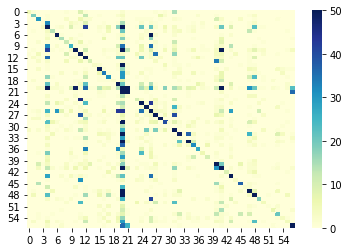

In [ ]:
seaborn.heatmap(confusion_matrix(cat_true,cat_pred),cmap="YlGnBu",vmax=50)

### Pattern Confusion Matrix

For this attribute category 10 is extremely problematic. Most of the other categories perform well. This corresponds to 'None' indicating a solid color.  This is not surprising and is likely due to confusing labeling in the other categories. In the data cleaning all images with null values were assigned 'None' but some of these could have also been missing data instead of an indication that there was no pattern present. It should also be noted that although most of the errors are concentrated in this category, it is also what the vast majority of the images were classified as.

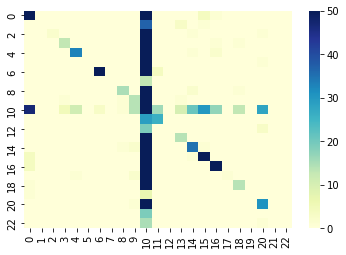

In [ ]:
import seaborn
seaborn.heatmap(confusion_matrix(pat_true,pat_pred),vmax=50,cmap="YlGnBu")

### Color Confusion Matrix

Errors for color are distributed across categories although 1, 11, and 13 seem to be particularly problematic.  This corresponds to Black, Red, and White. To increase accuracy, one would need to more closely examine labeling for these images.

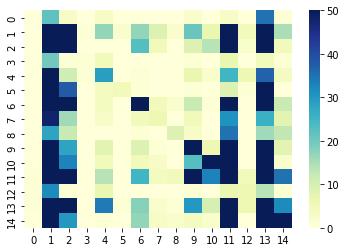

In [ ]:
seaborn.heatmap(confusion_matrix(col_true,col_pred),cmap="YlGnBu",vmax=50)

# Prediction Pipeline

Now that the model has been trained, the pipeline has to be developed to retrieve Instagram images, assign annotations, and store them in a database to be used for a Google Data Studio report.  This process is outlined in the second notebook.

# Conclusions

This project is a proof of concept that demonstrates how to provide more detailed Instagram fashion trend data to end users using a neural network that can assign three different attributes to pictured clothing. 

The model used is 48% accurate for category of clothing, 75% accurate for pattern, and 53% accurate for color. Due to resource and time constraints the model could not be developed further, but there are many avenues available to improve the outcomes and it already shows a much higher ability to assign annotations that random guessing among the options.

The report was produced using 6 hashtags popular among fashion influencers to retrieve fashion images from Instagram posts. However, to have a broad overview of fashion trend data it would be important to carefully select hashtags, consider targeting certain user accounts (known influencers or set threshold for minimum number of followers), and ensure a sufficient quantity is collected.  These adjustments could easily be made in the second notebook for the prediction pipeline after sufficient research was done.